# <center> Relazione 4 </center>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

from scipy.optimize import curve_fit

In [2]:
#Riporto i valori degli osservabili ottenuti mediante simulazione
energia_kin = np.loadtxt("Osservabili/EnergiaKin.dat", unpack=True)
energia_pot = np.loadtxt("Osservabili/EnergiaPot.dat", unpack=True)
energia_tot = np.loadtxt("Osservabili/EnergiaTot.dat", unpack=True)
temperatura = np.loadtxt("Osservabili/Temp.dat", unpack=True)
pressione = np.loadtxt("Osservabili/Press.dat", unpack=True)

L'obiettivo dell'esercitazione 4 è simulare via Molecular Dynamics il comportamento di un sistema di atomi di Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) nelle seguenti condizioni:
1. fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cut-off: $r_c = 2.2$)

2. fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cut-off: $r_c = 2.5$)

3. fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off: $r_c = 5.0$)

dove gli asterischi indicano che stiamo lavorando in unità ridotte.

Siamo in particolare interessati ai seguenti osservabili:

- Energia interna per particella: $\frac{E}{N}$

- Energia cinetica per particella: $\frac{K}{N}$

- Energia potenziale per particella: $\frac{U}{N}$

- Temperatura: $T$

- Pressione: $P$

## Molecular Dynamics

L'ensamble micro-canonico è un insieme statistico che descrive i sistemi isolati, cioè quei sistemi che hanno un valore definito di energia, volume e numero di particelle. Esso si basa su due postulati. Consideriamo un fluido costituito da N particelle contenute in un box di volume V. 
1. **Postulato 1** - le costanti del moto rilevanti sono l'energia $E$, la quantità di moto totale $\vec{P}$ ed il momento angolare totale $\vec{L}$

2. **Postulato 2** - i microstati caratterizzati dalla stessa energia $E$ sono equi-probabili (noto come "postulato dell'uguale probabilità a priori"). 

Il Molecular dynamics (MD) è un metodo di simulazione numerica che consente di analizzare il movimento di atomi e molecole: per poter evolvere le posizioni e le velocità degli atomi è in primo luogo necessario fornire delle informazioni sul potenziale di interazione. Per la simulazione di questa esercitazione (e anche della 7) lavoreremo con il potenziale di Lennard-Jones:
$$V\left(r\right)\,=\,4\mathcal{E}\left[\left(\frac{\sigma}{r}\right)^{12}\,-\,\left(\frac{\sigma}{r}\right)^{6}\right]$$
dove $\mathcal{E}$ è la profondità della buca di potenziale e σ è la distanza alla quale avviene il cambio di segno del potenziale. Dal potenziale è possibile ricavare le forze che agiscono sulle singole particelle e di conseguenza le varie accelerazioni: note le $a_i$ è poi possibile ricavare le future posizioni.

#### Algoritmo di Verlet

L'algoritmo di Verlet è un metodo alle differenze finite che consiste nell'utilizzo di due espansioni di Taylor al terzo ordine, una di $+\,\delta t$ e l'altra di $-\,\delta t$. Ho che:

$$\vec{r}\left(t\,+\,\delta t\right)\,=\,\vec{r}\left(t\right)\,+\,\delta t\vec{v}\left(t\right)\,+\,\frac{1}{2}\delta t^2\,\vec{a}\left(t\right)\,+\,\frac{1}{3!}\delta t^3\,\dot{\vec{a}}\left(t\right)\,+\,\mathcal{O}\left(\delta t^4\right)$$
$$\vec{r}\left(t\,-\,\delta t\right)\,=\,\vec{r}\left(t\right)\,-\,\delta t\vec{v}\left(t\right)\,+\,\frac{1}{2}\delta t^2\,\vec{a}\left(t\right)\,-\,\frac{1}{3!}\delta t^3\,\dot{\vec{a}}\left(t\right)\,+\,\mathcal{O}\left(\delta t^4\right)$$

Sommando membro a membro le due uguaglianze quello che ottengo è che:
$$
\vec{r}\left(t\,+\,\delta t\right)\,\simeq\,2\vec{r}\left(t\right)\,-\,\vec{r}\left(r\,-\,\delta t\right)\,+\,\delta t^2\,\vec{a}\left(t\right)
$$
La posizione al tempo successivo dipende quindi sia da quella in cui mi trovo al tempo $t$ che da quella occupata all'istante di tempo precedente: per effettuare un passo è sempre necessario avere in memoria due configurazioni. Il codice utilizzato per l'esercitazione 4 presenta una leggera modifica, poichè per iniziare l'evoluzione del sistema non vengono fornite due configurazioni, ma una sola. La seconda viene ricavata una volta generate gaussianamente le velocità delle molecole se non utilizzo il metodo del restart, altrimenti mediante le velocità contenute nel file "velocity.out". Durante tutta l'esecuzione del codice viene anche tenuta traccia delle velocità delle singole molecole:
$$
\vec{v}\left(t\,+\,\delta t\right)\,=\,\frac{\vec{r}\left(t\,+\delta t\right)\,-\,\vec{r}\left(t\,-\,\delta t\right)}{2\delta t}
$$

#### Periodic boundary condition

Per studiare le proprietà del bulk di un sistema non è possibile lavorare con un singolo box contenente un certo numero di molecole: le interazioni con le pareti risulterebbero essere troppo impattanti. Per ottenere il risultato che ci siamo posti il box analizzato viene replicato nello spazio fino a creare un reticolo infinito: ogni volta che una molecola si muove nel box originale, anche la sua immagine periodica nelle varie repliche del box effettua lo stesso spostamento. La "densità di particelle" nel box centrale è quindi conservata, poichè quando una molecola esce dal lato opposto del box entrerà quella che fino a prima era la sua immagine. La comodità di questo modo di procedere è che non è necessario memorizzare le coordinate di tutte le molecole, ma solo di quelle del box centrale. Inoltre se il potenziale è short-range (come Lennard-Jones) il fatto che il reticolo sia simmetrico non risulta evidente.

#### Energia potenziale

Il cuore della simulazione consiste nel calcolare l'energia potenziale di una certa configurazione: chiaramente non è possibile considerare tutte le immagini delle particelle nelle repliche del box di partenza. Per valutare l'interazione della molecola 1 con le altre ci si pone sulla stessa e si effettua un cut-off sferico del potenziale: solo le particelle la cui distanza dalla numero 1 è minore di $r_{cut}$ verranno considerate come interagenti. Questo metodo è chiaramente impreciso, in quanto non si tiene conto di tutte le possibili interazioni: è tuttavia possibile effettare delle tail correction che garantiscono la correttezza dei risultati numerici.

<span style="color: blue;">

## Termalizzazione

</span>

In [3]:
eq_gas = np.loadtxt("Equilibrazioni/Gassoso.dat", unpack=True)
eq_liq = np.loadtxt("Equilibrazioni/Liquido.dat", unpack=True)
eq_sol = np.loadtxt("Equilibrazioni/Solido.dat", unpack=True)

Il sistema viene sempre inizializzato in una configurazione cristallina: se non si vuole simulare un solido il cristallo si scioglierà nelle prime fasi della simulazione. Si sceglie una configurazione di questo genere come punto di partenza perchè quelle generate casualmente possono facilmente dare luogo a sovrapposizioni fra particelle con conseguenti spike nel valore del potenziale di interazione a causa del core di $V\left(r\right)$, la cui natura è fortemente repulsiva. 
<br>
Monitorando la temperatura, si osserva che nelle prime fasi della simulazione si ha una forte caduta di $T$ per il caso del liquido e del solido, mentre nella fase gassosa si presenta il comportamento opposto ($T$ aumenta). La spiegazione di questo fenomeno è che stiamo lavorando ad $E$ totale del sistema fissata: un aumento del valore del potenziale (che ha segno negativo) si traduce in una diminuzione dell'energia cinetica. Dato lo stretto legame:
$$
K\,=\,\frac{3}{2}Nk_{B}T
$$
fra energia cinetica e temperatura, una diminuzione della prima si ripercuote direttamente sulla seconda grandezza. Per lavorare nelle condizioni termodinamiche richieste (vedi inizio relazione) ho quindi eseguito più volte il codice per capire che temperature di input fossero necessarie per poi trovarmi a lavorare nel contesto voluto. In particolare ho trovato che:

$$
\begin{cases}
    T_{in,\,gas}\,=\,0.955 \\
    T_{in,\,liq}\,=\,1.9864 \\
    T_{in,\,sol}\,=\,1.542
\end{cases}
$$

Riporto in seguito le termalizzazioni per le 3 fasi. La temperatura è monitorata istantaneamente, ossia ne effettuo una stima dopo ogni MD move.

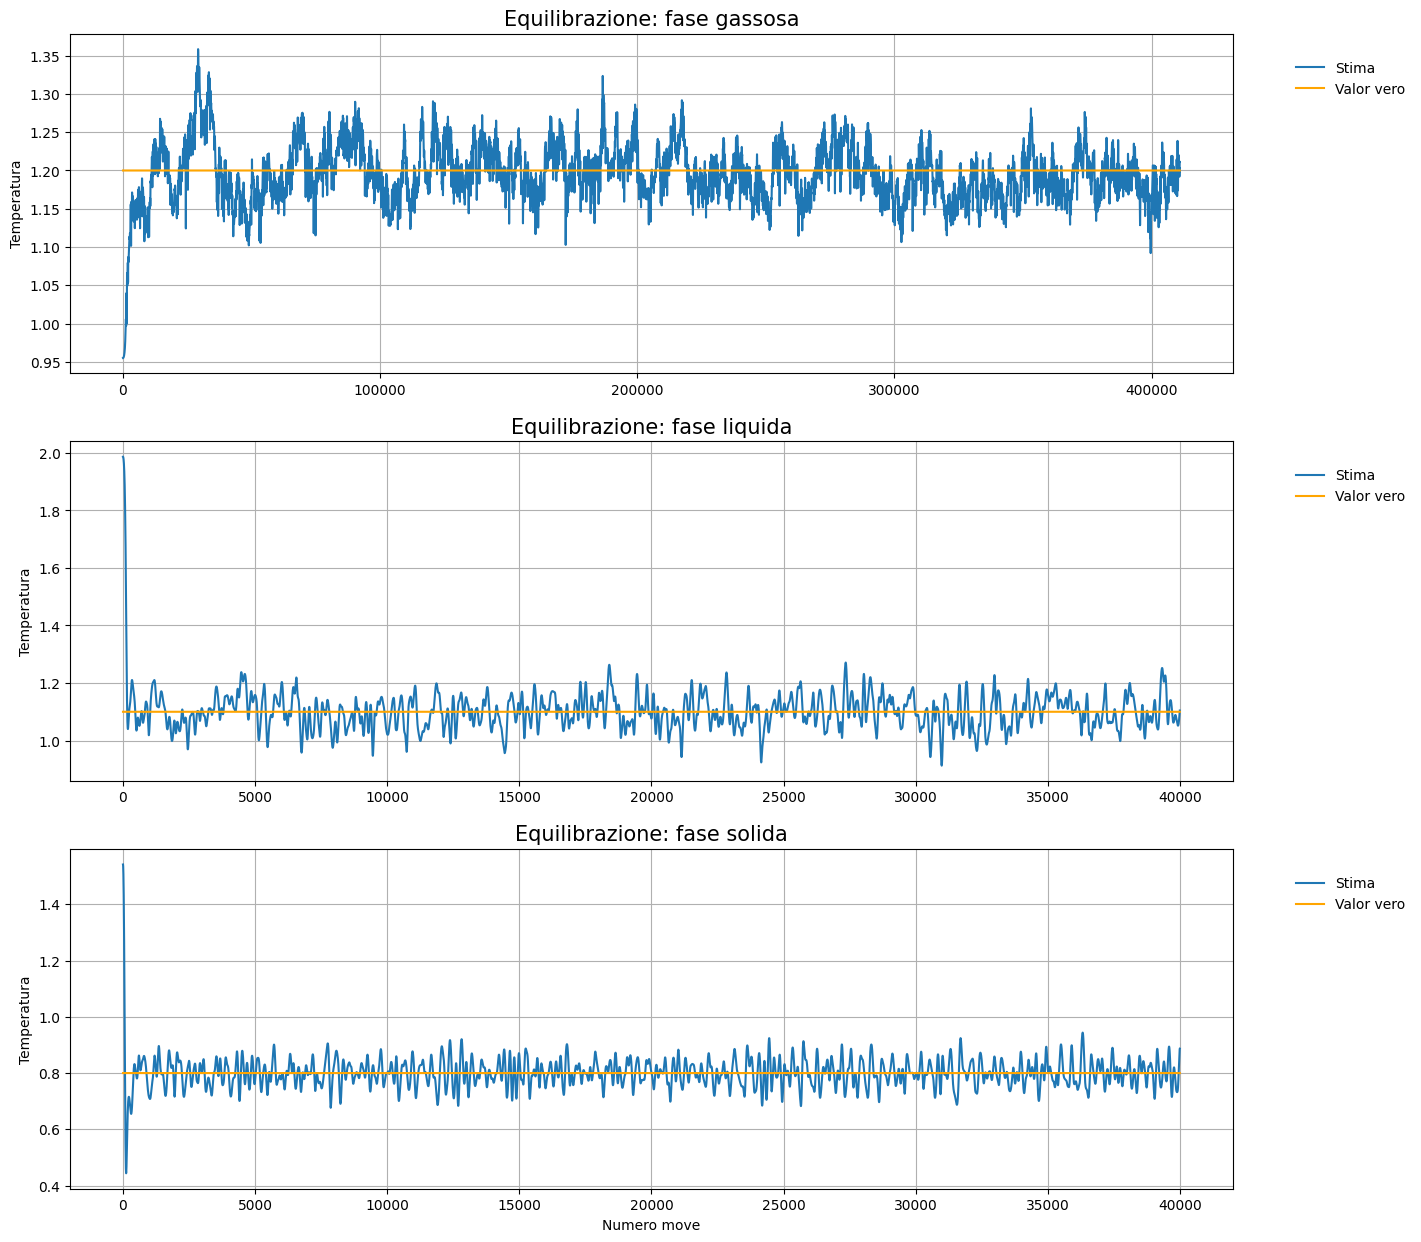

In [4]:
fig, ax = plt.subplots(3,1, figsize = (15, 15))
T = np.array([1.2, 1.1, 0.8])
titolo = np.array(['fase gassosa', 'fase liquida', 'fase solida'])

for j in range(0, 3):

    if j==0:
        x = np.array([i for i in range(0, 411000)])
        ax[j].plot(x, eq_gas[1, 0 : 411000], label = 'Stima')
        ax[j].plot(x, np.array([T[j] for i in range(0, len(x))]), label = 'Valor vero', color = 'orange')

    else:
        if j==1:
            val = eq_liq[1, :]
        else:
            val = eq_sol[1, :]

        x = np.array([i for i in range(0, len(val))])
        ax[j].plot(x, val, label = 'Stima')
        ax[j].plot(x, np.array([T[j] for i in range(0, len(x))]), label = 'Valor vero', color = 'orange')
    
    ax[j].legend(loc=(1.05, 0.8), frameon=False)
    ax[j].set_title('Equilibrazione: ' + titolo[j], fontsize = '15')
    ax[j].set_ylabel('Temperatura')
    ax[j].grid(True)

ax[2].set_xlabel("Numero move")

plt.show()

Osservando le tre equilibrazioni notiamo che le oscillazioni in temperatura del gas avvengono su tempi molto maggiori: per questo motivo ho scelto di lavorare su un intervallo 10 volte più lungo (400000 rispetto che 40000). Per determinare quando posso considerare finita la fase di termalizzazione mi concentro per i vari grafici sulle fasi iniziali dell'evoluzione del sistema.

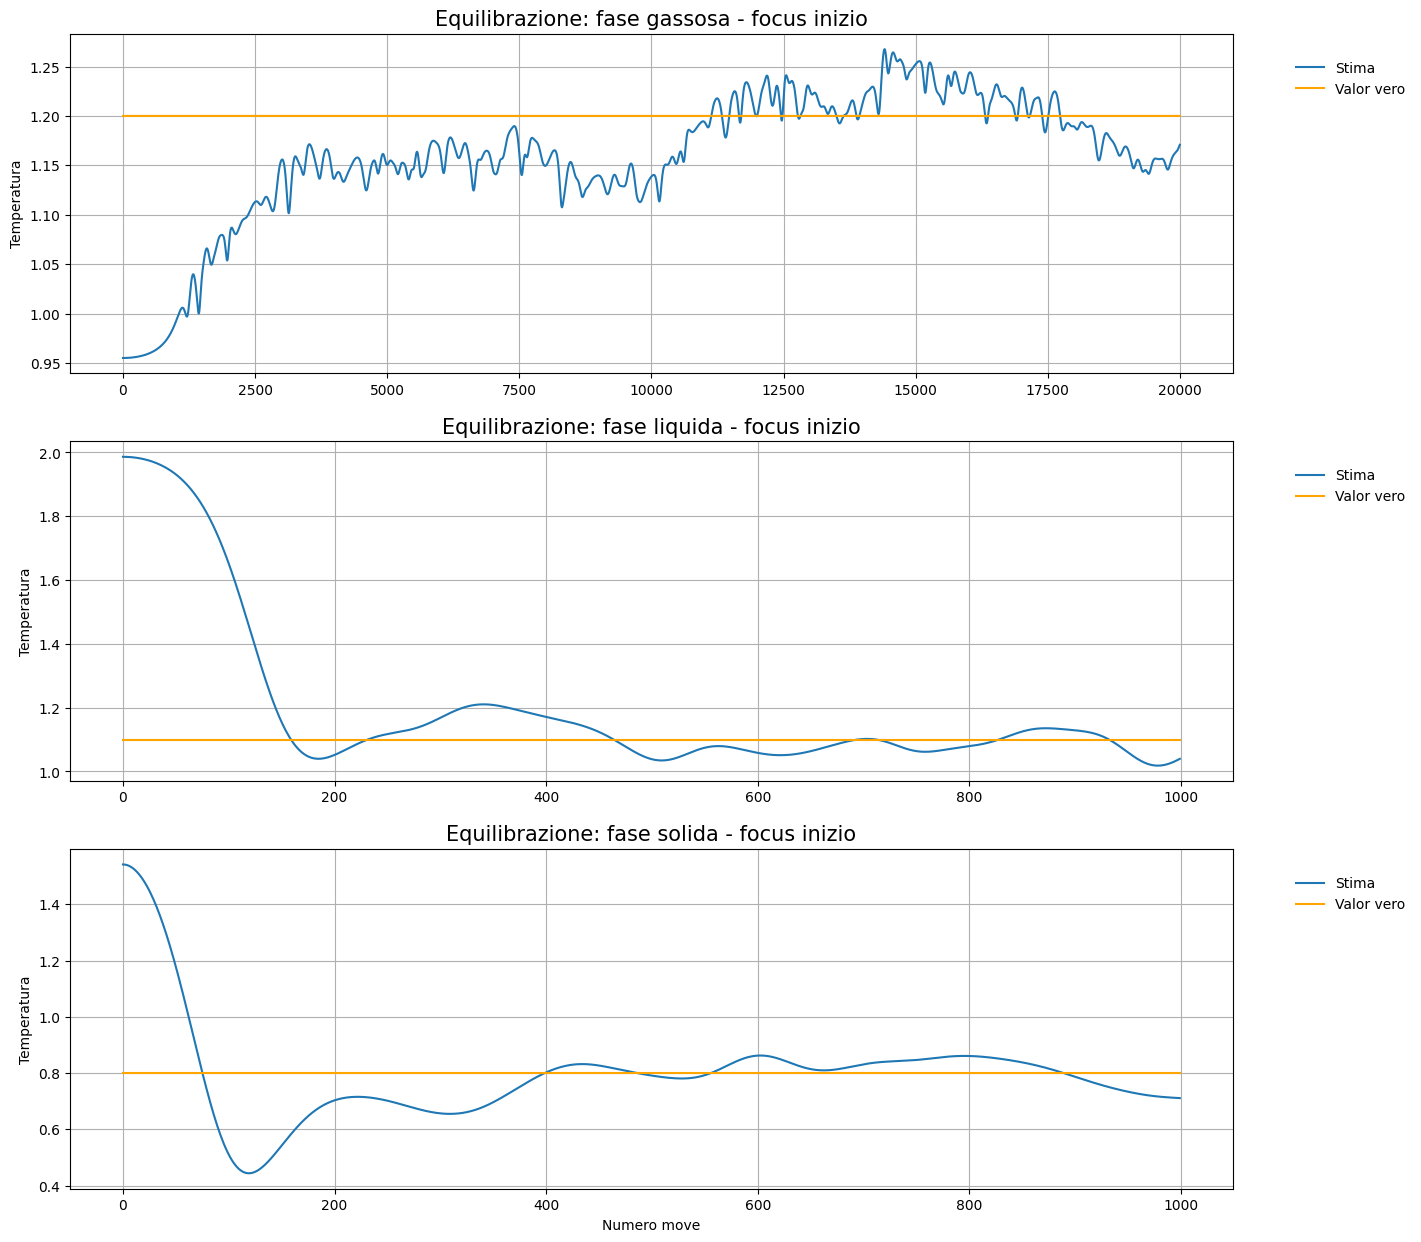

In [5]:
fig, ax = plt.subplots(3,1, figsize = (15, 15))
T = np.array([1.2, 1.1, 0.8])
titoli = np.array(['fase gassosa - focus inizio', 'fase liquida - focus inizio', 'fase solida - focus inizio'])

for j in range(0, 3):

    if j==0:
        x = np.array([i for i in range(0, 20000)])
        ax[j].plot(x, eq_gas[1, 0 : 20000], label = 'Stima')
        ax[j].plot(x, np.array([T[j] for i in range(0, len(x))]), label = 'Valor vero', color = 'orange')

    else:
        if j==1:
            val = eq_liq[1, 0:1000]
        else:
            val = eq_sol[1, 0:1000]

        x = np.array([i for i in range(0, len(val))])
        ax[j].plot(x, val, label = 'Stima')
        ax[j].plot(x, np.array([T[j] for i in range(0, len(x))]), label = 'Valor vero', color = 'orange')
    
    ax[j].legend(loc=(1.05, 0.8), frameon=False)
    ax[j].set_title('Equilibrazione: ' + titoli[j], fontsize = '15')
    ax[j].set_ylabel('Temperatura')
    ax[j].grid(True)

ax[2].set_xlabel("Numero move")

plt.show()

Considero le equilibrazioni terminate dopo un numero di singole MD move pari a:
$$
\begin{cases}
    N_{gas}\,=\,11000 \\
    N_{liq}\,=\,200 \\
    N_{sol}\,=\,300
\end{cases}
$$
Sebbene a livello visivo dopo tale numero di step la temperatura istantanea sembri oscillare nell'intorno della temperatura richiesta per tutte e tre le fasi, voglio la conferma numerica: per questo motivo faccio la media delle temperature istantanee scartando le prime $N_{fase}$ mosse.

In [6]:
for j in range(0, 3):
    if j==0:
        val = eq_gas[1, 11000 : 411000]
    elif j==1:
        val = eq_liq[1, 200 : 40000]
    elif j==2:
        val = eq_sol[1, 300 : 40000]

    #Contenitori per media e media2
    media = 0
    media2 = 0

    for i in range(0, len(val)):
        media = media * i/(i+1) + val[i]/(i+1)
        media2 = media2 * i/(i+1) + val[i] * val[i]/(i+1)

    print("La temperatura media calcolata con il sistema in " + titolo[j] + " è: " + str(round(media, 4)))
    print("L'errore associato a questa stima è: " + str(round(math.sqrt((media2 - media*media)/(len(val) - 1)), 4))+'\n')


La temperatura media calcolata con il sistema in fase gassosa è: 1.1994
L'errore associato a questa stima è: 0.0001

La temperatura media calcolata con il sistema in fase liquida è: 1.0997
L'errore associato a questa stima è: 0.0003

La temperatura media calcolata con il sistema in fase solida è: 0.7999
L'errore associato a questa stima è: 0.0002



### Problema con metodo restart

In [7]:
NoRestart = np.loadtxt("Dubbi/NoRestart.dat", unpack=True)
SiRestart = np.loadtxt("Dubbi/SiRestart.dat", unpack=True)

Durante le varie simulazioni che ho effettuato per svolgere l'esercitazioni, ho notato un comportamento abbastanza singolare del metodo restart (molto evidente nel caso del gas). Una volta equilibrato il sistema a $T\simeq 1.2$ e stampate le posizioni e le velocità rispettivamente nei files: "config.out" e "velocity.out" utilizzavo restart per eseguire una simulazione partendo già dal sistema termalizzato. Il valore di aspettazione della temperatura risultava però essere abbastanza diverso da 1.2, infatti $T\,\ge\,1.21$ e l'andamento delle stime istantanee di temperatura era nettamente differente se utilizzavo restart oppure no. La spiegazione di quanto osservato sta nel fatto che la velocità viene stampata a file con sole 6 cifre decimali (o comunque non massima precisione) e che per ripartire il programma trova le $\vec{r}\left(t\,-\,\delta t\right)$ partendo dalle $\vec{v}$. Questi piccoli errori di approssimazione portano il sistema a percorrere due traiettorie differenti nello spazio delle fasi, che dopo un certo numero di mosse (circa 10000) diventano visivamente distinte anche a livello macroscopico date le diverse temperature.

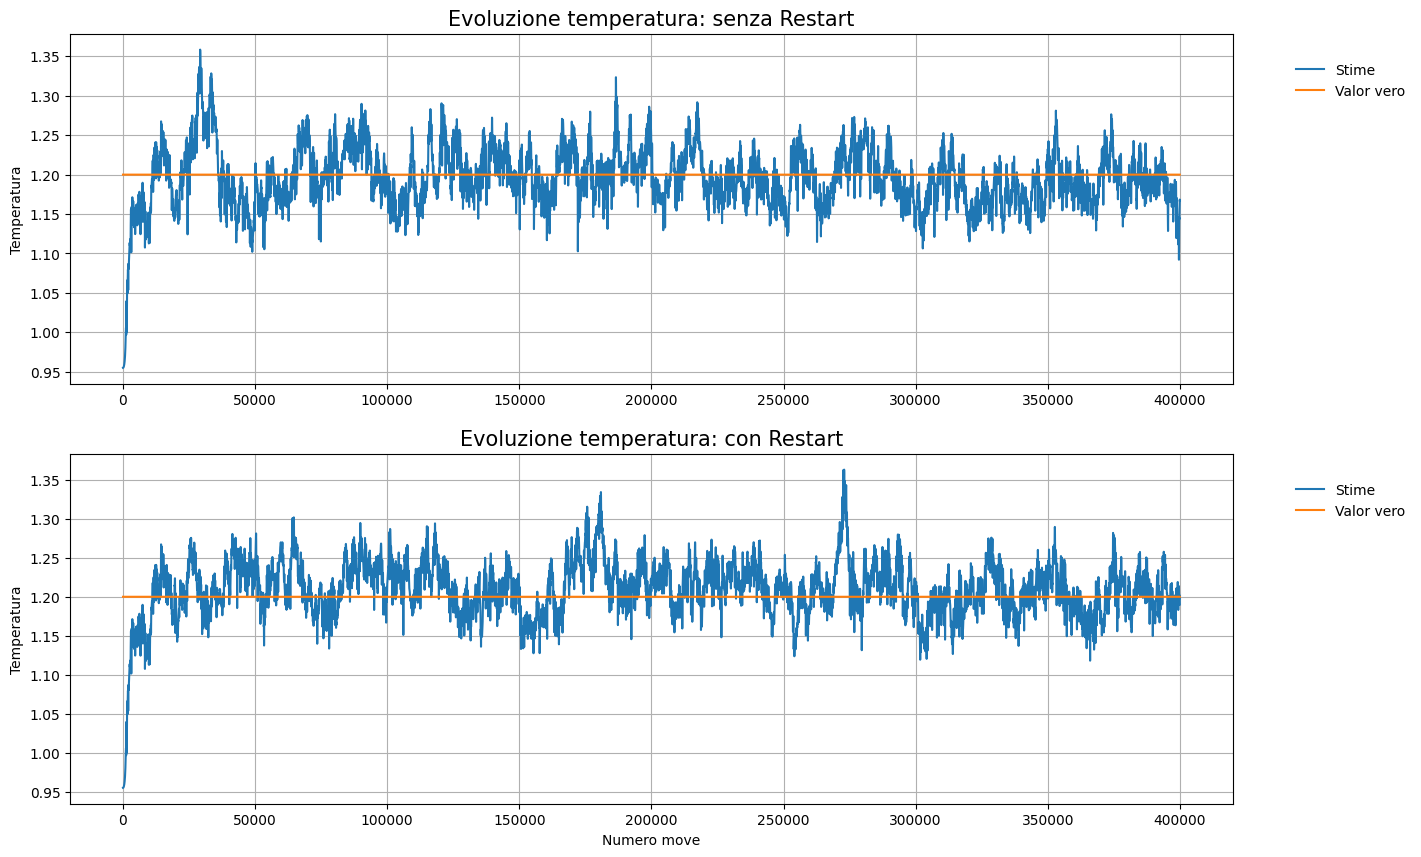

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
titolo = np.array(['senza Restart', 'con Restart'])

for j in range(0, 2):
    x = np.array([i  for i in range(0, 400000)])

    if j==0:
        ax[j].plot(x, NoRestart[1, 50000 : 450000], label = "Stime")

    else:
        ax[j].plot(x, SiRestart[1, 50000 : 450000], label = "Stime")

    ax[j].plot(x, np.array([T[0] for i in x]), label = "Valor vero")
    ax[j].legend(loc=(1.05, 0.8), frameon=False)

    ax[j].set_title(f"Evoluzione temperatura: " + titolo[j], fontsize = '15')
    ax[j].set_ylabel('Temperatura')
    ax[j].grid(True)

ax[1].set_xlabel('Numero move')

plt.show()

Effettuo come in precedenza la stima della temperatura senza considerare la fase in cui avviene l'equilibrazione. Ciò che trovo è quanto segue:

In [9]:
for j in range(0, 2):
    if j==0:
        val = NoRestart[1, 60000 : 450000]
    else:
        val = SiRestart[1, 60000 : 450000]

    #Contenitori per media e media2
    media = 0
    media2 = 0

    for i in range(0, len(val)):
        media = media * i/(i+1) + val[i]/(i+1)
        media2 = media2 * i/(i+1) + val[i] * val[i]/(i+1)

    print("La temperatura media calcolata " + titolo[j] + " è: " + str(round(media, 4)))
    print("L'errore associato a questa stima è: " + str(round(math.sqrt((media2 - media*media)/(len(val) - 1)), 4))+'\n')

La temperatura media calcolata senza Restart è: 1.1996
L'errore associato a questa stima è: 0.0001

La temperatura media calcolata con Restart è: 1.2138
L'errore associato a questa stima è: 0.0001



Dato che le equilibrazioni sono molto veloci e mi dava fastidio eseguire una simulazione lungo una traiettoria nello spazio delle fasi che non era quella che testavo con la termalizzazione, ho deciso che non avrei utilizzato il metodo restart. Ho infatti modificato il programma in modo tale che avesse un input ulteriore da file, chiamato term, il cui significato era il numero di move che dovevo fare a vuoto prima di iniziare a misurare. Chiaramente questo comporta un aumento delle tempistiche di esecuzione, poichè ogni volta il sistema va equilibrato, ma per quanto stiamo facendo noi non è più di qualche secondo.

<center>
<span style="color: blue;">

## Simulazione

</span>
</center>

Le simulazioni delle tre fasi sono effettuate con $N\,=\,20$ blocchi. La dimensione dei blocchi è di $n\,=\,2000$ per la fase solida e quella liquida, mentre nel caso del gas ho che $n\,=\,20000$ per ovviare alle oscillazioni lunghe in temperatura. Il gas è la fase più difficile da trattare perchè è posto in delle condizioni termodinamiche che consentono la formazione di piccoli cluster di atomi, come se il sistema tentasse di condensare.

<span style="color: blue;">

## Temperatura

</span>

Per prima cosa voglio verificare se ho rispettato le condizioni richieste per le varie fasi e per questo motivo grafico la temperatura progressiva.

La temperatura in fase gassosa è: 1.1994
L'errore associato a questa stima è: 0.0032

La temperatura in fase liquida è: 1.0997
L'errore associato a questa stima è: 0.0036

La temperatura in fase solida è: 0.8001
L'errore associato a questa stima è: 0.0008



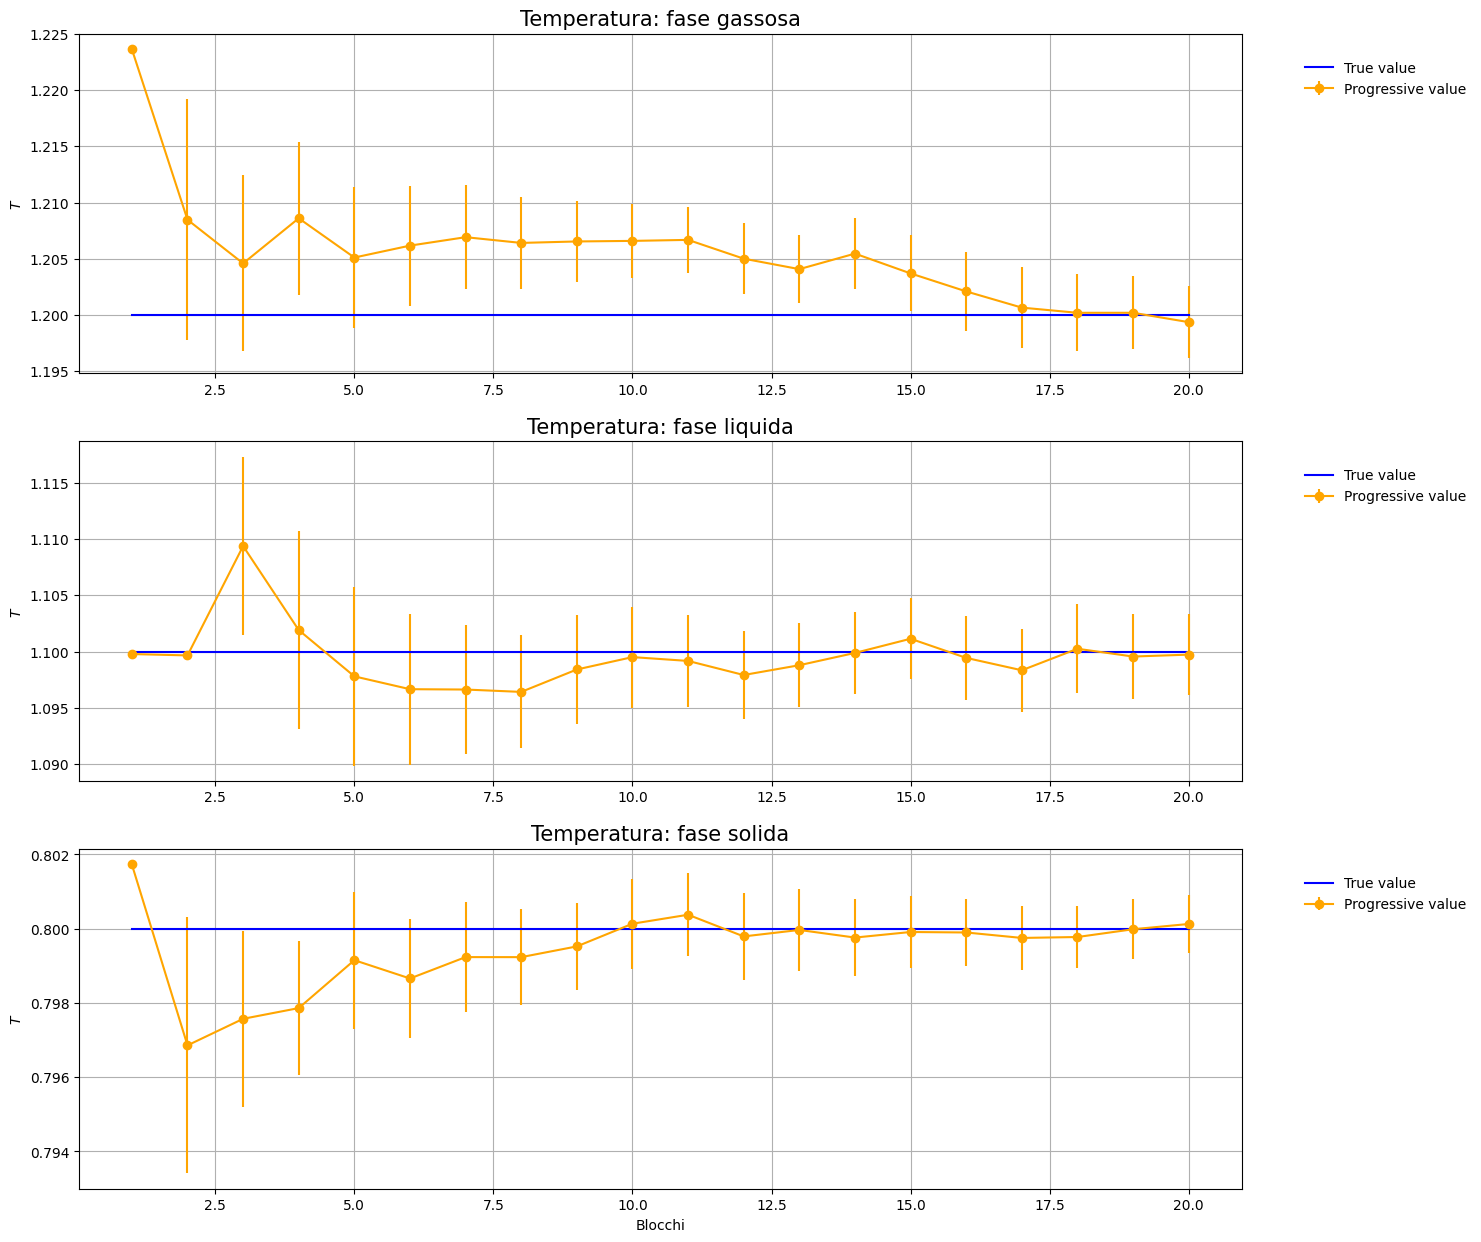

In [10]:
fig, ax = plt.subplots(3, 1, figsize = (15, 15))
titoli = np.array(['fase gassosa', 'fase liquida', 'fase solida'])
T = np.array([1.2, 1.1, 0.8])


for i in range(0, 3):
    ax[i].errorbar(temperatura[0, 20*i:20*(1+i)], temperatura[2, 20*i:20*(1+i)], yerr = temperatura[3, 20*i:20*(1+i)], label = "Progressive value", color = 'orange', fmt = 'o-')
    ax[i].plot(temperatura[0, 20*i:20*(1+i)], np.array([T[i] for j in range(0, 20)]), label = 'True value', color = 'blue')
    
    ax[i].set_title('Temperatura: ' + titoli[i], fontsize = '15')
    ax[i].legend(loc=(1.05, 0.8), frameon=False)
    ax[i].set_ylabel(r'$T$')
    ax[i].grid(True)

    print("La temperatura in " + titoli[i] + " è: " + str(round(temperatura[2, 20*(i+1)-1], 4)))
    print("L'errore associato a questa stima è: " + str(round(temperatura[3, 20*(i+1)-1], 4))+'\n')
    

ax[2].set_xlabel('Blocchi')
plt.show()

Come riportato in precedenza, la fase che risulta un po' più complicata da termalizzare è quella gassosa: questo si traduce in una mancanza di compatibilità ad un sigma della $T_{prog}$ con il valor vero per un numero abbastanza significativo di blocchi.

<span style="color: blue;">

## Energia potenziale

</span>

L'energia potenziale per particella in fase gassosa è: -0.3995
L'errore associato a questa stima è: 0.0048

L'energia potenziale per particella in fase liquida è: -5.0186
L'errore associato a questa stima è: 0.0056

L'energia potenziale per particella in fase solida è: -6.6601
L'errore associato a questa stima è: 0.0012



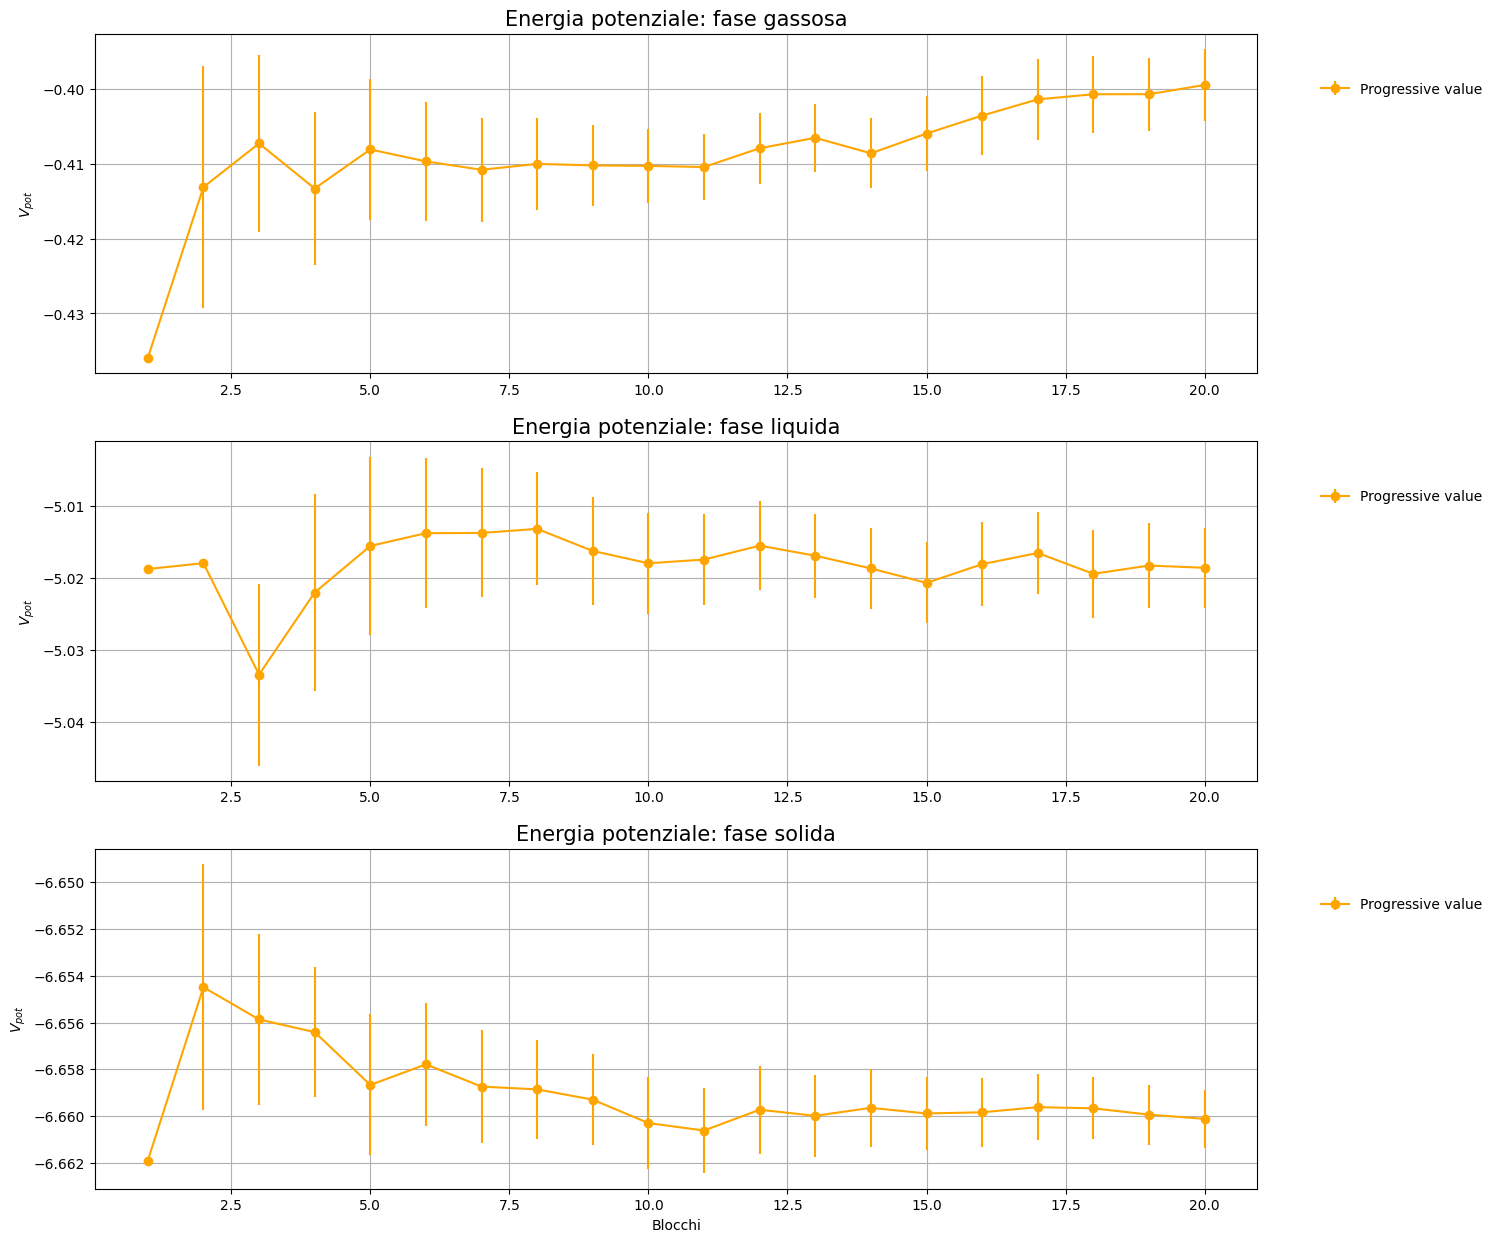

In [11]:
fig, ax = plt.subplots(3, 1, figsize = (15, 15))
titoli = np.array(['fase gassosa', 'fase liquida', 'fase solida'])


for i in range(0, 3):
    ax[i].errorbar(energia_pot[0, 20*i:20*(1+i)], energia_pot[2, 20*i:20*(1+i)], yerr = energia_pot[3, 20*i:20*(1+i)], label = "Progressive value", color = 'orange', fmt = 'o-')
    
    ax[i].set_title('Energia potenziale: ' + titoli[i], fontsize = '15')
    ax[i].legend(loc=(1.05, 0.8), frameon=False)
    ax[i].set_ylabel(r'$V_{pot}$')
    ax[i].grid(True)

    print("L'energia potenziale per particella in " + titoli[i] + " è: " + str(round(energia_pot[2, 20*(i+1)-1], 4)))
    print("L'errore associato a questa stima è: " + str(round(energia_pot[3, 20*(i+1)-1], 4))+'\n')
    

ax[2].set_xlabel('Blocchi')
plt.show()

Notiamo che l'energia potenziale minore è associata alla fase solida. I valori graficati sono tuttavia errati a causa del potential cut-off utilizzato: saranno necessarie delle tail correction (vedi esercitazione 7) per ottenere dei valori corretti.

<span style="color: blue;">

## Energia cinetica

</span>

L'energia cinetica per particella in fase gassosa è: 1.7991
L'errore associato a questa stima è: 0.0048

L'energia cinetica per particella in fase liquida è: 1.6496
L'errore associato a questa stima è: 0.0054

L'energia cinetica per particella in fase solida è: 1.2002
L'errore associato a questa stima è: 0.0012



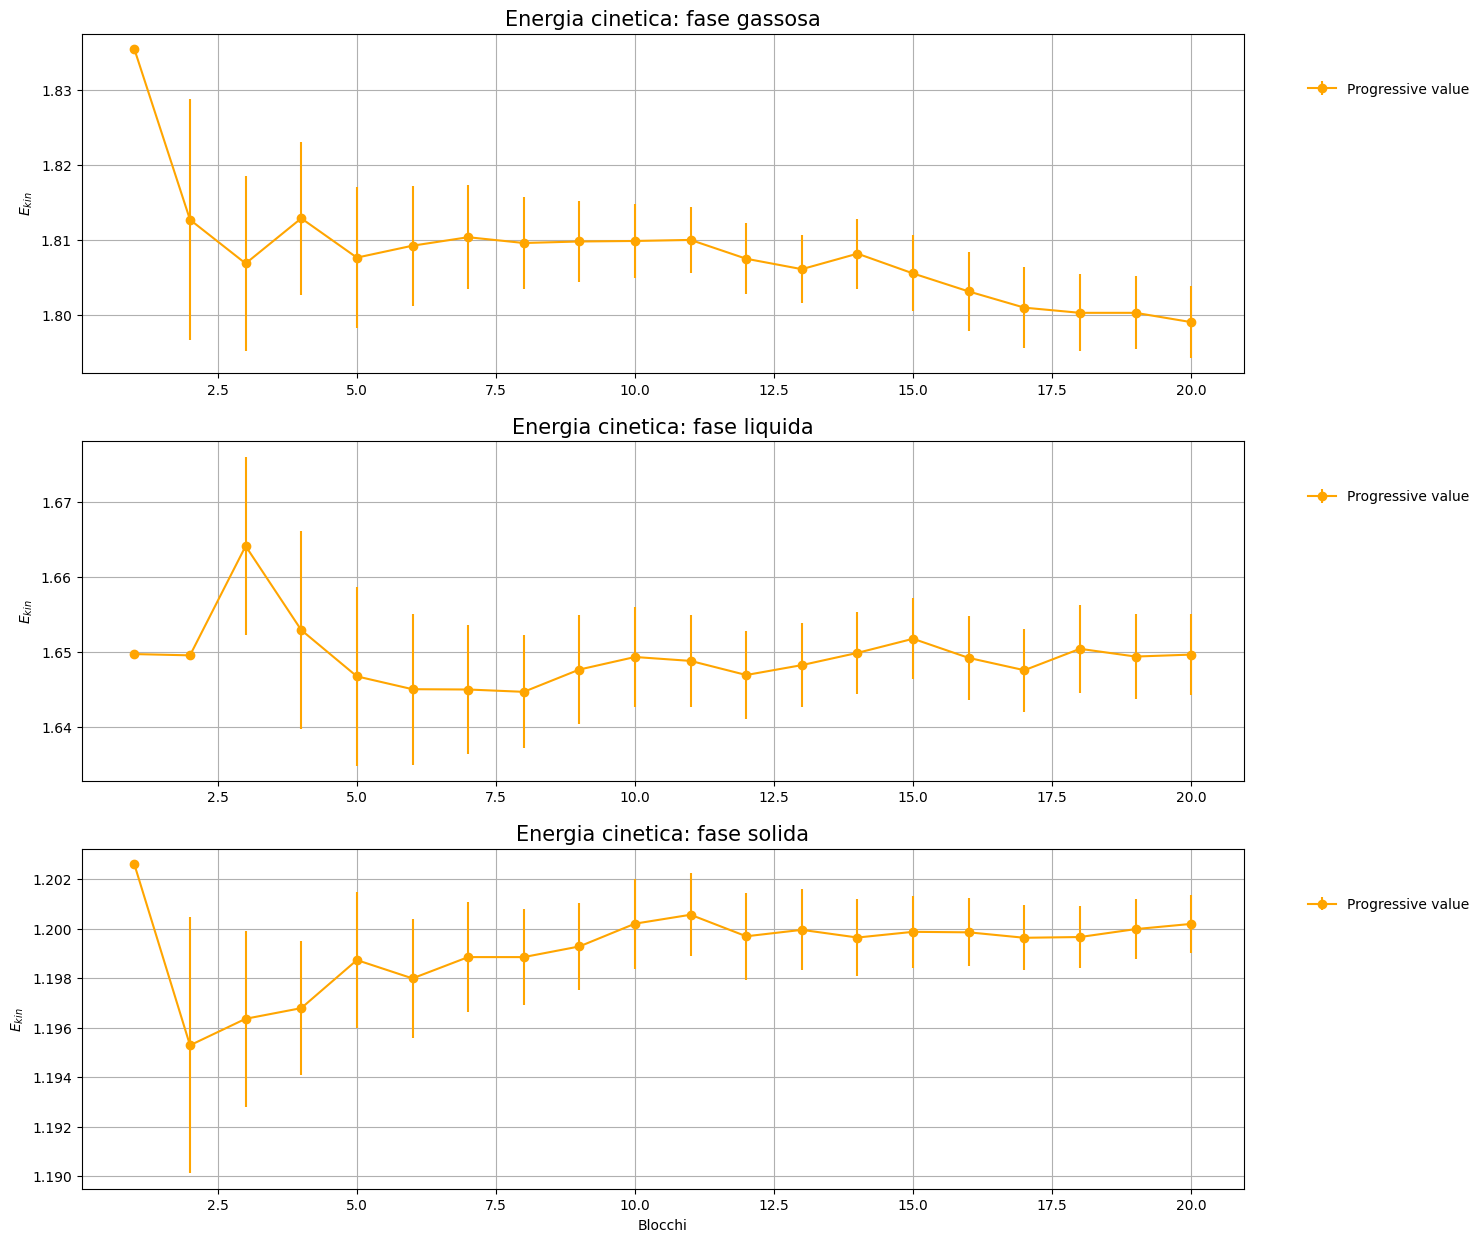

In [12]:
fig, ax = plt.subplots(3, 1, figsize = (15, 15))
titoli = np.array(['fase gassosa', 'fase liquida', 'fase solida'])


for i in range(0, 3):
    ax[i].errorbar(energia_kin[0, 20*i:20*(1+i)], energia_kin[2, 20*i:20*(1+i)], yerr = energia_kin[3, 20*i:20*(1+i)], label = "Progressive value", color = 'orange', fmt = 'o-')
    
    ax[i].set_title('Energia cinetica: ' + titoli[i], fontsize = '15')
    ax[i].legend(loc=(1.05, 0.8), frameon=False)
    ax[i].set_ylabel(r'$E_{kin}$')
    ax[i].grid(True)

    print("L'energia cinetica per particella in " + titoli[i] + " è: " + str(round(energia_kin[2, 20*(i+1)-1], 4)))
    print("L'errore associato a questa stima è: " + str(round(energia_kin[3, 20*(i+1)-1], 4))+'\n')
    

ax[2].set_xlabel('Blocchi')
plt.show()

Dato che sappiamo che la temperatura e l'energia cinetica sono strettamente legate:
$$
E_{kin}\,=\,\frac{3}{2}k_{B}T
$$
notiamo che presentano come ci aspettavamo lo stesso andamento (solamente riscalato).

<span style="color: blue;">

## Energia totale

</span>

L'energia totale per particella in fase gassosa è: 1.3996
L'errore associato a questa stima è: 0.0

L'energia totale per particella in fase liquida è: -3.369
L'errore associato a questa stima è: 0.0003

L'energia totale per particella in fase solida è: -5.4599
L'errore associato a questa stima è: 0.0001



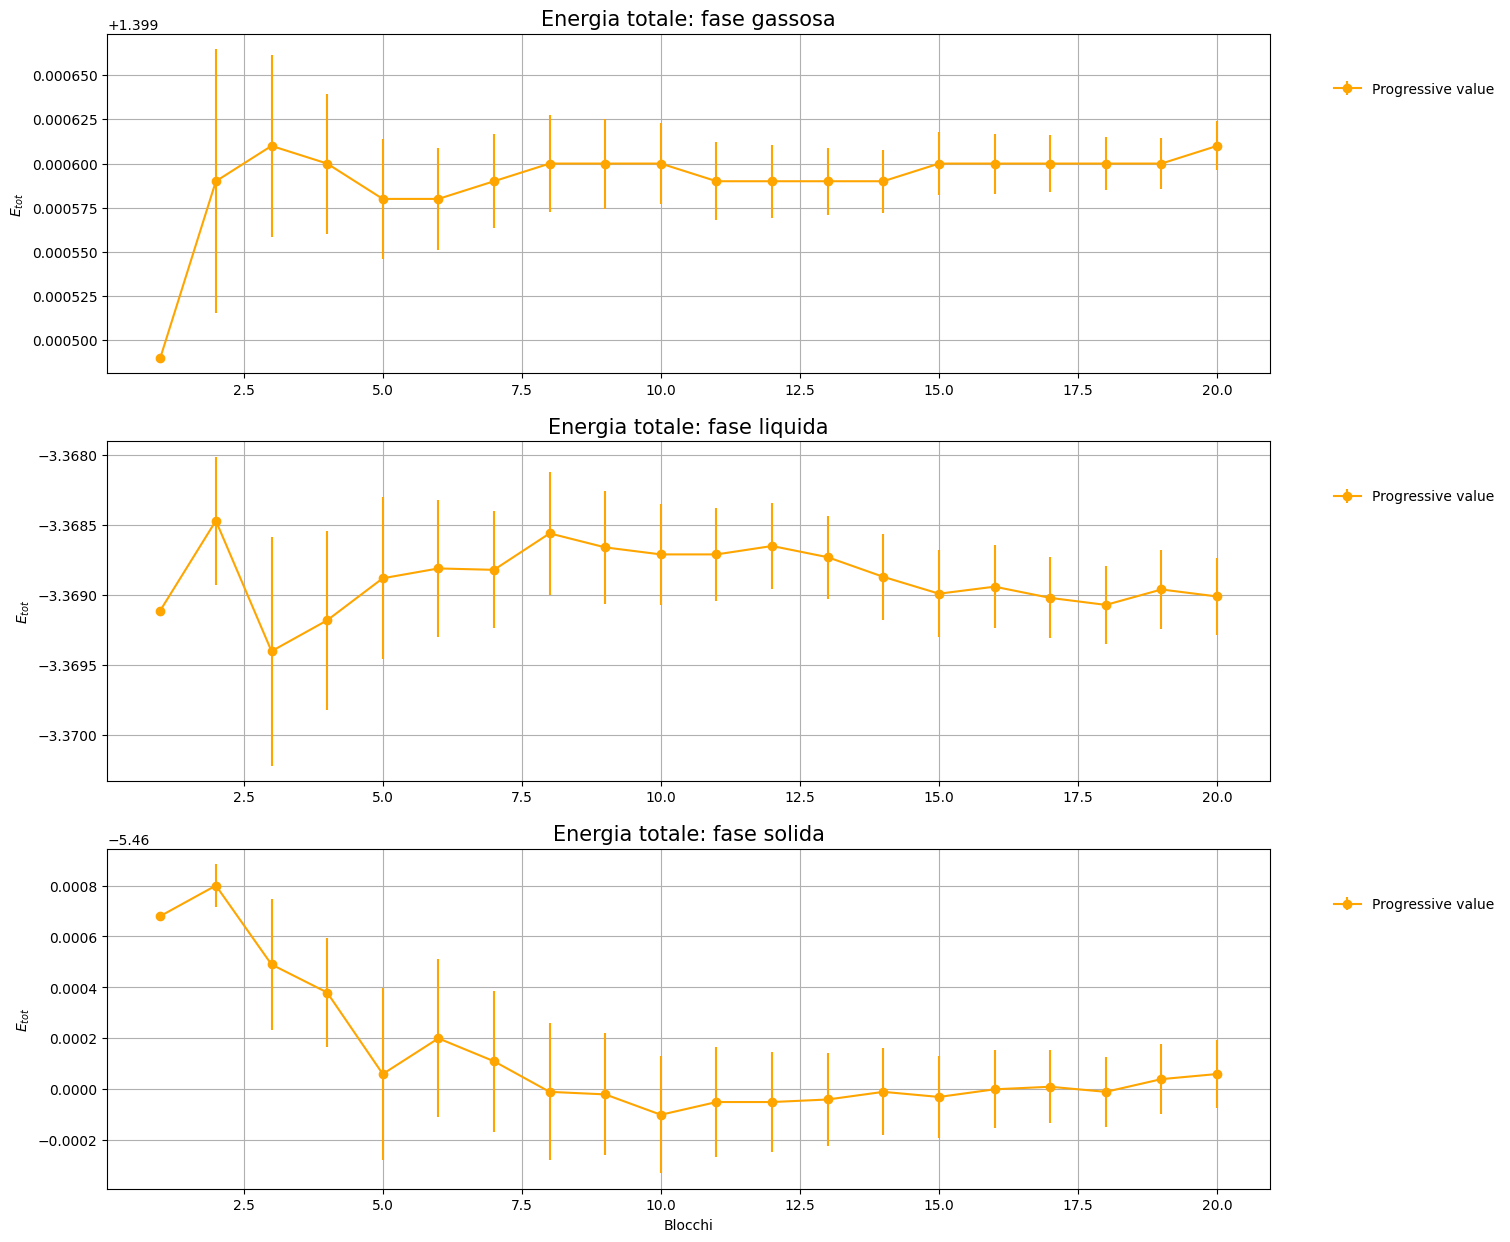

In [13]:
fig, ax = plt.subplots(3, 1, figsize = (15, 15))
titoli = np.array(['fase gassosa', 'fase liquida', 'fase solida'])


for i in range(0, 3):
    ax[i].errorbar(energia_tot[0, 20*i:20*(1+i)], energia_tot[2, 20*i:20*(1+i)], yerr = energia_tot[3, 20*i:20*(1+i)], label = "Progressive value", color = 'orange', fmt = 'o-')
    
    ax[i].set_title('Energia totale: ' + titoli[i], fontsize = '15')
    ax[i].legend(loc=(1.05, 0.8), frameon=False)
    ax[i].set_ylabel(r'$E_{tot}$')
    ax[i].grid(True)

    print("L'energia totale per particella in " + titoli[i] + " è: " + str(round(energia_tot[2, 20*(i+1)-1], 4)))
    print("L'errore associato a questa stima è: " + str(round(energia_tot[3, 20*(i+1)-1], 4))+'\n')
    

ax[2].set_xlabel('Blocchi')
plt.show()

Il MD è un metodo che mantiene costante l'energia del sistema: questo si traduce in barre d'errore molto piccole associate alle stime di $E_{tot}$.

<span style="color: blue;">

## Pressione

</span>

Per mezzo del teorema del viriale, la pressione può essere stimata come:

$$ P = \rho k_B T + \frac{1}{3V} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48\epsilon \left[ \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - 
\frac{1}{2} \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^6 \right] \right\rangle $$

Il calcolo di $P$ si basa su quello del potenziale: anche per questo osservabile termodinamico sarà necessaria una tail correction.

La pressione in fase gassosa è: 0.0496
L'errore associato a questa stima è: 0.0001

La pressione in fase liquida è: 2.1657
L'errore associato a questa stima è: 0.0291

La pressione in fase solida è: 9.6161
L'errore associato a questa stima è: 0.0057



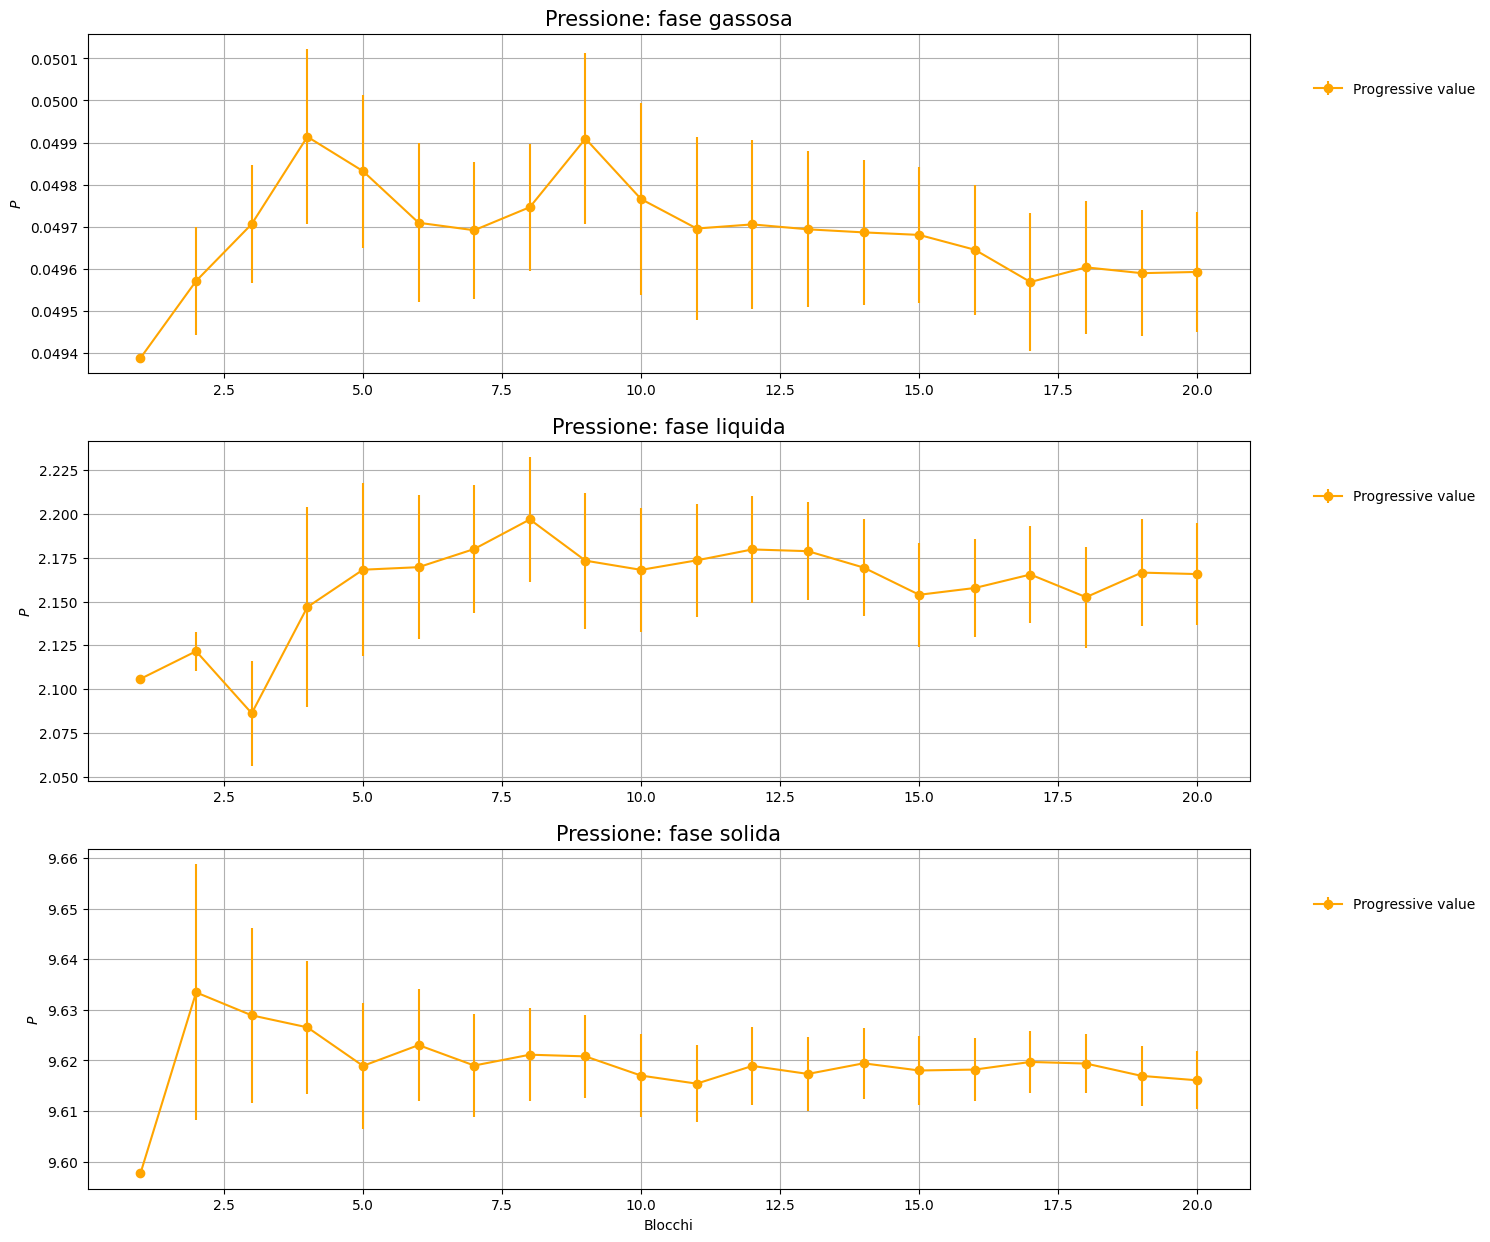

In [14]:
fig, ax = plt.subplots(3, 1, figsize = (15, 15))
titoli = np.array(['fase gassosa', 'fase liquida', 'fase solida'])


for i in range(0, 3):
    ax[i].errorbar(pressione[0, 20*i:20*(1+i)], pressione[2, 20*i:20*(1+i)], yerr = pressione[3, 20*i:20*(1+i)], label = "Progressive value", color = 'orange', fmt = 'o-')
    
    ax[i].set_title('Pressione: ' + titoli[i], fontsize = '15')
    ax[i].legend(loc=(1.05, 0.8), frameon=False)
    ax[i].set_ylabel(r'$P$')
    ax[i].grid(True)

    print("La pressione in " + titoli[i] + " è: " + str(round(pressione[2, 20*(i+1)-1], 4)))
    print("L'errore associato a questa stima è: " + str(round(pressione[3, 20*(i+1)-1], 4))+'\n')
    

ax[2].set_xlabel('Blocchi')
plt.show()